## Binary Classification for Dwarfs and Giants
Nic Annau, UVic, July 2018 nannau@uvic.ca

Software requirements: catalogue.py

In [1]:
from catalogue import *

Using TensorFlow backend.


## Load data from catalogues. 
### Apply colour cut such that we remove everything except for giants and dwarfs.
----

In [2]:
inputs, outputs, error, df_original = load_data()
print "Number of stars:", inputs.shape[0]
print "Shape of inputs, outputs, and error from loading data..."
print inputs.shape, outputs.shape, error.shape

inputs['u-g'] = inputs['u'].subtract(inputs['g'])
inputs['u-i'] = inputs['u'].subtract(inputs['i'])
inputs['g-r'] = inputs['g'].subtract(inputs['r'])
inputs['g-z'] = inputs['g'].subtract(inputs['z'])

m = 0.42 # u - g
b = 0.28 # g - r

# Apply a color cut to remove the contaminent stars (i.e. that are not giants or dwarfs)
colour_cut_a = (m*inputs['u-g'] - b > inputs['g-r'])
colour_cut_b = (m*inputs['u-g'] - b <= inputs['g-r']) #& (m*inputs['u-g'] + b > inputs['g-r'])

a_star=inputs[colour_cut_a]
outputs=outputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
error=error[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
inputs=inputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 

# Apply the color cuts for machine learning 
# Remove these colour cuts and see if it changes model significantly.
ui_thres = 1.3
gz_thres = 0.05

# Select only the lowest error in logg
logg_error_thres = 0.16

ml_cut =  (inputs['u-i'] >= ui_thres) & (inputs['u-i'] <= 2.6) & (inputs['g-z'] >= gz_thres)

# Apply above ml_cut
input_forML2 = inputs#[ml_cut]
output_forML2 = outputs#[ml_cut]
error_forML2 = error#[ml_cut]

# Apply above loegg error threshold. i.e. select only stars with good logg data
logg_cut = (error_forML2['dlogg'] <= logg_error_thres)

# Randomize the index after cuts, and assign to new inputs for ML
input_ML2 = input_forML2[logg_cut].reset_index(drop=True)
output_ML2 = output_forML2[logg_cut].reset_index(drop=True)
error_ML2 = error_forML2[logg_cut].reset_index(drop=True)

# For binary classification, we need to set the threshold for which
# logg we decide is a dwarf or a giant
output_ML2['logg_binary'] = np.where(output_ML2['logg'] > 3.5, 'dwarf', 'giant')

print "Number of stars after machine logg cuts:", input_ML2.shape[0]

/opt/conda/lib/python2.7/site-packages/pandas/core/frame.py:5085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


Number of stars: 142750
Shape of inputs, outputs, and error from loading data...
(142750, 9) (142750, 3) (142750, 3)
Number of stars after machine logg cuts: 121280


### Initialize machine learning inputs, Neural Network layers, and Stratified K-fold Cross Validation

In [3]:
seed = 7 # Removes any predictablility in our k-fold splits. Completely random.
epochs=100 # specify number of epochs per split
batch_size =1000 # batch size


np.random.seed(seed)

# Normalize input data to simplify model
inputf = normalize(input_ML2)
outputf = normalize(output_ML2)
errorf = normalize(error_ML2, 'min_max')

# Train on colours
inputs_col = pd.DataFrame()
#u-g,g-r,r-i,i-z
inputs_col['u-g']=inputf['u']-inputf['g']
inputs_col['g-r']=inputf['g']-inputf['r']
inputs_col['r-i']=inputf['r']-inputf['i']
inputs_col['i-z']=inputf['i']-inputf['z']
inputs_col['z-y']=inputf['z']-inputf['y']
inputs_col['u-G']=inputf['u']-inputf['G']
inputs_col['u-RP']=inputf['u']-inputf['RP']
inputs_col['u-BP']=inputf['u']-inputf['BP']

# convert our inputs into a numpy array
X = inputs_col.values.astype(float)

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=8, kernel_initializer='normal', activation='relu')) #input_dim=13,
    model.add(Dense(5096, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(outputf['logg_binary'])
encoded_Y = encoder.transform(outputf['logg_binary'])

new_model = True # True only if you want to cross-validate a model with new parameters.

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
estimator = KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch_size, verbose=1)

# Build and test model
if new_model:
    # evaluate model with standardized dataset
    print "Baseline creation..."
    y_pred = cross_val_predict(estimator, X, encoded_Y, cv=kfold, n_jobs = 3)
    y_val = (y_pred, encoded_Y)
    pickle.dump(y_val, open( "./pickle/binary_class_pred.pickle", "wb" ) )

# load results from previous model. 
else:
    y_val = pickle.load(open( "./pickle/binary_class_pred.pickle", "rb" ))
    
# create a confusion matrix.     
conf_mat = confusion_matrix(encoded_Y, y_pred)
y_true = pd.Series(outputf['logg_binary'])
# Get the names of our classes back
y_predicted = encoder.inverse_transform(y_pred[:,0])
y_prd = pd.Series(y_predicted)

# display confusion matrix
display(pd.crosstab(y_true, y_prd, rownames=['True'], colnames=['Predicted'], margins=True))

cm = conf_mat

tp0, fn, fp, tp1 = map(float, cm.ravel())

tp = tp0+tp1
precision = tp/(tp+fp)
accuracy = (tp0+tp1)/ (tp0+tp1+fn+fp)
recall = tp/(tp+fn)
recall_1 = tp0/(tp0+fn)
recall_2 = tp1/(tp1+fn)
F1 = 2*(recall * precision) / (recall + precision)
completeness = tp0/(tp0+fp)
purity = tp1/(tp1+fp)
print "Accuracy:", accuracy
print "Precision:", precision
print "Recall:",recall, recall_1, recall_2
print "F1:", F1
print "Completeness:", completeness
print "Purity:", purity

Baseline creation...
Epoch 1/100
Epoch 1/100
Epoch 1/100
80854/80854 [==============================] - 7s 92us/step - loss: 0.4054 - acc: 0.8508
Epoch 2/100
80854/80854 [==============================] - 7s 93us/step - loss: 0.4084 - acc: 0.8504
Epoch 2/100
Epoch 2/100
80852/80852 [==============================] - 7s 84us/step - loss: 0.3158 - acc: 0.8630
Epoch 3/100
80854/80854 [==============================] - 7s 86us/step - loss: 0.3184 - acc: 0.8608
Epoch 3/100
80852/80852 [==============================] - 7s 86us/step - loss: 0.2924 - acc: 0.8749
Epoch 4/100
80854/80854 [==============================] - 7s 86us/step - loss: 0.2971 - acc: 0.8716
Epoch 4/100
80854/80854 [==============================] - 7s 83us/step - loss: 0.2764 - acc: 0.8816
Epoch 5/100
80852/80852 [==============================] - 7s 86us/step - loss: 0.2737 - acc: 0.8848
Epoch 5/100
80854/80854 [==============================] - 7s 86us/step - loss: 0.2770 - acc: 0.8808
Epoch 5/100
80854/80854 [=========

80854/80854 [==============================] - 7s 85us/step - loss: 0.2085 - acc: 0.9147
Epoch 26/100
80852/80852 [==============================] - 7s 85us/step - loss: 0.2081 - acc: 0.9138
Epoch 27/100
80854/80854 [==============================] - 7s 85us/step - loss: 0.2122 - acc: 0.9127
Epoch 27/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.2036 - acc: 0.9168
Epoch 27/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.2081 - acc: 0.9146
Epoch 28/100
80852/80852 [==============================] - 7s 85us/step - loss: 0.2084 - acc: 0.9142
Epoch 28/100
80852/80852 [==============================] - 7s 84us/step - loss: 0.2044 - acc: 0.9155
Epoch 29/100
80854/80854 [==============================] - 7s 85us/step - loss: 0.2048 - acc: 0.9157
Epoch 29/100
80854/80854 [==============================] - 7s 83us/step - loss: 0.1987 - acc: 0.9189
Epoch 29/100
80852/80852 [==============================] - 7s 85us/step - loss: 0.2000 - acc: 

80852/80852 [==============================] - 7s 86us/step - loss: 0.1549 - acc: 0.9380
Epoch 50/100
80854/80854 [==============================] - 7s 85us/step - loss: 0.1567 - acc: 0.9379
Epoch 50/100
80854/80854 [==============================] - 7s 86us/step - loss: 0.1580 - acc: 0.9363
Epoch 51/100
80852/80852 [==============================] - 7s 85us/step - loss: 0.1584 - acc: 0.9357
Epoch 51/100
80854/80854 [==============================] - 7s 86us/step - loss: 0.1582 - acc: 0.9367
Epoch 51/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.1609 - acc: 0.9363
Epoch 52/100
80852/80852 [==============================] - 7s 84us/step - loss: 0.1520 - acc: 0.9391
Epoch 52/100
80854/80854 [==============================] - 7s 87us/step - loss: 0.1525 - acc: 0.9395
Epoch 52/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.1547 - acc: 0.9391
Epoch 53/100
80854/80854 [==============================] - 7s 83us/step - loss: 0.1507 - acc: 

80854/80854 [==============================] - 7s 84us/step - loss: 0.1051 - acc: 0.9601
Epoch 74/100
80852/80852 [==============================] - 7s 84us/step - loss: 0.0969 - acc: 0.9632
Epoch 74/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.0913 - acc: 0.9661
Epoch 74/100
80854/80854 [==============================] - 7s 85us/step - loss: 0.0979 - acc: 0.9618
Epoch 75/100
80852/80852 [==============================] - 7s 84us/step - loss: 0.0954 - acc: 0.9638
Epoch 75/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.0870 - acc: 0.9678
Epoch 75/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.0934 - acc: 0.9653
Epoch 76/100
80852/80852 [==============================] - 7s 85us/step - loss: 0.0936 - acc: 0.9642
Epoch 76/100
80854/80854 [==============================] - 7s 82us/step - loss: 0.0873 - acc: 0.9681
Epoch 76/100
80854/80854 [==============================] - 7s 81us/step - loss: 0.0948 - acc: 

80854/80854 [==============================] - 7s 82us/step - loss: 0.0497 - acc: 0.9840
Epoch 97/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.0477 - acc: 0.9842
Epoch 98/100
80852/80852 [==============================] - 7s 82us/step - loss: 0.0501 - acc: 0.9836
Epoch 98/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.0434 - acc: 0.9867
Epoch 98/100
80854/80854 [==============================] - 7s 85us/step - loss: 0.0451 - acc: 0.9863
Epoch 99/100
80854/80854 [==============================] - 7s 83us/step - loss: 0.0460 - acc: 0.9859
Epoch 99/100
80854/80854 [==============================] - 7s 81us/step - loss: 0.0496 - acc: 0.9840
Epoch 100/100
80852/80852 [==============================] - 7s 84us/step - loss: 0.0503 - acc: 0.9832
Epoch 100/100
80854/80854 [==============================] - 7s 84us/step - loss: 0.0483 - acc: 0.9848
Epoch 100/100
40426/40426 [==============================] - 1s 12us/step


/opt/conda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted,dwarf,giant,All
True,,,
dwarf,103142,599,103741
giant,2159,15380,17539
All,105301,15979,121280


Accuracy: 0.977259234828
Precision: 0.982109859879
Recall: 0.994971499568 0.994226005147 0.962513298705
F1: 0.98849884488
Completeness: 0.979496870875
Purity: 0.876902902104


### Plot an ROC curve to visualize results of the confusion matrix and model on Milky Way set.

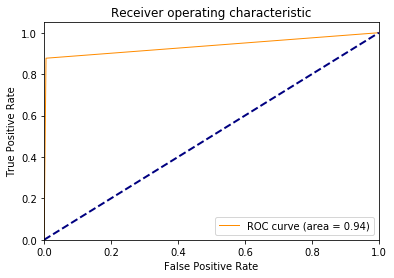

In [4]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(encoded_Y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Show the results of the classification in $T_{eff}$ and $\log{g}$ space.

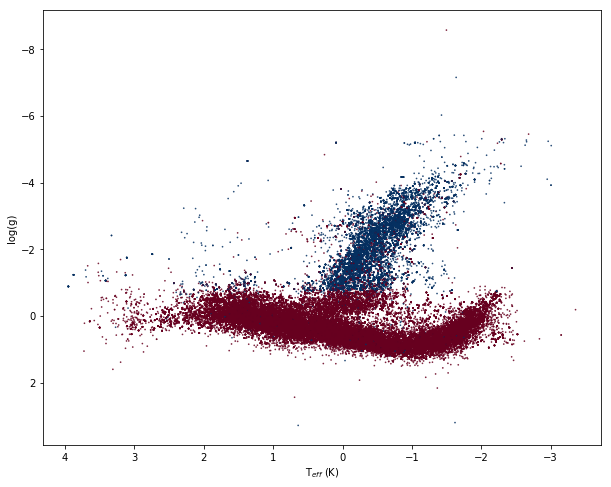

In [5]:
outputf['class_pred'] = y_pred
# Plot the position of the stars in a Teff-logg diagram
plt.figure(figsize=(10,8))
plt.scatter(outputf['Teff'].values, outputf['logg'].values, s=0.5,rasterized=True, c=outputf['class_pred'],alpha=0.8,edgecolors=None, cmap=plt.cm.RdBu)
plt.xlabel('T$_{eff}$ (K)')
plt.ylabel('log(g)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

### Build a model that uses all of the input data set for use with the globular clusters.

In [24]:
estimator.fit(X, encoded_Y, epochs=200, batch_size=1000, verbose=1)

Epoch 1/200
121280/121280 [==============================] - 5s 38us/step - loss: 0.3744 - acc: 0.8518
Epoch 2/200
121280/121280 [==============================] - 4s 34us/step - loss: 0.2969 - acc: 0.8739
Epoch 3/200
121280/121280 [==============================] - 4s 33us/step - loss: 0.2683 - acc: 0.8865
Epoch 4/200
121280/121280 [==============================] - 4s 34us/step - loss: 0.2565 - acc: 0.8915
Epoch 5/200
121280/121280 [==============================] - 4s 35us/step - loss: 0.2495 - acc: 0.8947
Epoch 6/200
121280/121280 [==============================] - 4s 34us/step - loss: 0.2414 - acc: 0.8987
Epoch 7/200
121280/121280 [==============================] - 4s 34us/step - loss: 0.2401 - acc: 0.8999
Epoch 8/200
121280/121280 [==============================] - 4s 34us/step - loss: 0.2307 - acc: 0.9040
Epoch 9/200
121280/121280 [==============================] - 4s 35us/step - loss: 0.2267 - acc: 0.9065
Epoch 10/200
121280/121280 [==============================] - 4s 34us/ste

121280/121280 [==============================] - 4s 36us/step - loss: 0.0248 - acc: 0.9927
Epoch 80/200
121280/121280 [==============================] - 5s 38us/step - loss: 0.0214 - acc: 0.9940
Epoch 81/200
121280/121280 [==============================] - 4s 37us/step - loss: 0.0548 - acc: 0.9805
Epoch 82/200
121280/121280 [==============================] - 5s 37us/step - loss: 0.0259 - acc: 0.9922
Epoch 83/200
121280/121280 [==============================] - 4s 35us/step - loss: 0.0211 - acc: 0.9940
Epoch 84/200
121280/121280 [==============================] - 4s 37us/step - loss: 0.0239 - acc: 0.9928
Epoch 85/200
121280/121280 [==============================] - 4s 36us/step - loss: 0.0306 - acc: 0.9898: 1s - loss: 0.
Epoch 86/200
121280/121280 [==============================] - 4s 36us/step - loss: 0.0318 - acc: 0.9897
Epoch 87/200
121280/121280 [==============================] - 4s 34us/step - loss: 0.0301 - acc: 0.9900
Epoch 88/200
121280/121280 [==============================] - 

Epoch 157/200
121280/121280 [==============================] - 4s 35us/step - loss: 0.0170 - acc: 0.9950
Epoch 158/200
121280/121280 [==============================] - 4s 34us/step - loss: 0.0093 - acc: 0.9974
Epoch 159/200
121280/121280 [==============================] - 4s 35us/step - loss: 0.0101 - acc: 0.9972
Epoch 160/200
121280/121280 [==============================] - 4s 36us/step - loss: 0.0113 - acc: 0.9966
Epoch 161/200
121280/121280 [==============================] - 4s 35us/step - loss: 0.0118 - acc: 0.9967
Epoch 162/200
121280/121280 [==============================] - 4s 35us/step - loss: 0.0119 - acc: 0.9966
Epoch 163/200
121280/121280 [==============================] - 4s 36us/step - loss: 0.0129 - acc: 0.9963
Epoch 164/200
121280/121280 [==============================] - 4s 36us/step - loss: 0.0309 - acc: 0.9901
Epoch 165/200
121280/121280 [==============================] - 4s 36us/step - loss: 0.0260 - acc: 0.9919
Epoch 166/200
121280/121280 [==========================

### Save model and weights. 

In [25]:
# keras library import  for Saving and loading model and weights
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = estimator.model.to_json()

with open("./models/2nd_col/model_num_3rd_A_col.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
estimator.model.save_weights("./models/2nd_col/model_num_3rd_A_col.h5")

### Define functions to create the inputs for testing with globular clusters, as well as cuts to those globular clusters.

In [26]:
def change_to_colour(input_test, input_train_col):
    # Make data to train on colours
    inputs_col = pd.DataFrame()

    inputs_col['u-g']=input_test['u']-input_test['g']
    inputs_col['g-r']=input_test['g']-input_test['r']
    inputs_col['r-i']=input_test['r']-input_test['i']
    inputs_col['i-z']=input_test['i']-input_test['z']
    inputs_col['z-y']=input_test['z']-input_test['y']
    inputs_col['u-G']=input_test['u']-input_test['G']
    inputs_col['u-RP']=input_test['u']-input_test['RP']
    inputs_col['u-BP']=input_test['u']-input_test['BP']
    
    inputs_col = normalize(inputs_col, df_1 = input_train_col, kind='custom')

    return inputs_col
 
def criteria_function(inputs_NGC, std_x, col_1, col_2):
    ra_cut = (inputs_NGC['pmra']>(inputs_NGC['pmra'].mean()-std_x*(inputs_NGC['pmra'].std()))) & (inputs_NGC['pmra']<(inputs_NGC['pmra'].mean()+std_x*(inputs_NGC['pmra'].std())))
    dec_cut = (inputs_NGC['pmdec']>(inputs_NGC['pmdec'].mean()-std_x*(inputs_NGC['pmdec'].std()))) & (inputs_NGC['pmdec']<(inputs_NGC['pmdec'].mean()+std_x*(inputs_NGC['pmdec'].std()))) 
    # Apply the color cuts for machine learning 
    ui_thres = 1.3
    gz_thres = 0.05
    #ml_cut =  (inputs_NGC['u']-inputs_NGC['i'] >= ui_thres) & (inputs_NGC['u']-inputs_NGC['i'] <= 2.6) & (inputs_NGC['g']-inputs_NGC['z'] >= gz_thres)
    criteria = ra_cut & dec_cut & (inputs_NGC['u']-inputs_NGC['G'] < col_1) & (inputs_NGC['u']-inputs_NGC['G'] > col_2)
    return criteria

### Load globular cluster data and apply proper motion cuts.

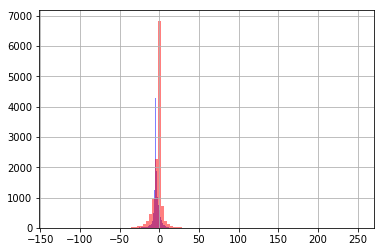

In [27]:
inputs_NGC6341 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6341.fits')
inputs_NGC6205 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6205.fits')
inputs_NGC5466 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5466.fits')
inputs_NGC5272 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5272.fits')

inputs_NGC6341['pmra'].std()

inputs_NGC6341['pmra'].hist(alpha=0.5, color='blue', bins=100)
inputs_NGC6341['pmdec'].hist(alpha=0.5, color='red', bins=100)
std_x  = 0.45

### Load and apply model to globular cluster data. 

In [28]:
# load weights into new model
json_file = open('./models/2nd_col/model_num_3rd_A_col.json', 'r')
loaded_model_json = json_file.read()

json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./models/2nd_col/model_num_3rd_A_col.h5")

##############################
## NGC 6341 ##
##############################
criteria = criteria_function(inputs_NGC6341, std_x, 2.5, 0)
inputs_NGC6341 = inputs_NGC6341[criteria]
print inputs_NGC6341.shape
inputs_NGC6341_b = change_to_colour(inputs_NGC6341, inputs_col)
print inputs_NGC6341_b.shape
inputs_NGC6341['class'] =  loaded_model.predict_classes(inputs_NGC6341_b.values)

    
##############################
## NGC 6205 ##
##############################
criteria = criteria_function(inputs_NGC6205, std_x, 2.5, 0)
inputs_NGC6205 = inputs_NGC6205[criteria]
inputs_NGC6205_b = change_to_colour(inputs_NGC6205, inputs_col)
inputs_NGC6205['class'] =  loaded_model.predict_classes(inputs_NGC6205_b.values)

##############################
## NGC 5466 ##
##############################
criteria = criteria_function(inputs_NGC5466, std_x, 2.5, 0)
inputs_NGC5466 = inputs_NGC5466[criteria]
inputs_NGC5466_b = change_to_colour(inputs_NGC5466, inputs_col)
inputs_NGC5466['class'] =  loaded_model.predict_classes(inputs_NGC5466_b.values)

##############################
## NGC 5272 ##
##############################
criteria = criteria_function(inputs_NGC5272, std_x, 2.5, 0)
inputs_NGC5272 = inputs_NGC5272[criteria]
inputs_NGC5272_b = change_to_colour(inputs_NGC5272, inputs_col)
inputs_NGC5272['class'] =  loaded_model.predict_classes(inputs_NGC5272_b.values)

inputs_NGC6341_giants = inputs_NGC6341[(inputs_NGC6341['class']==1)]
inputs_NGC6341_dwarfs = inputs_NGC6341[(inputs_NGC6341['class']==0)]

inputs_NGC6205_giants = inputs_NGC6205[(inputs_NGC6205['class']==1)]
inputs_NGC6205_dwarfs = inputs_NGC6205[(inputs_NGC6205['class']==0)]

inputs_NGC5466_giants = inputs_NGC5466[(inputs_NGC5466['class']==1)]
inputs_NGC5466_dwarfs = inputs_NGC5466[(inputs_NGC5466['class']==0)]

inputs_NGC5272_giants = inputs_NGC5272[(inputs_NGC5272['class']==1)]
inputs_NGC5272_dwarfs = inputs_NGC5272[(inputs_NGC5272['class']==0)]

print "Number of dwarfs NGC6341,", inputs_NGC6341_dwarfs.shape[0]
print "Number of giants NGC6341,", inputs_NGC6341_giants.shape[0]

(6310, 13)
(6310, 8)
Number of dwarfs NGC6341, 2576
Number of giants NGC6341, 3734


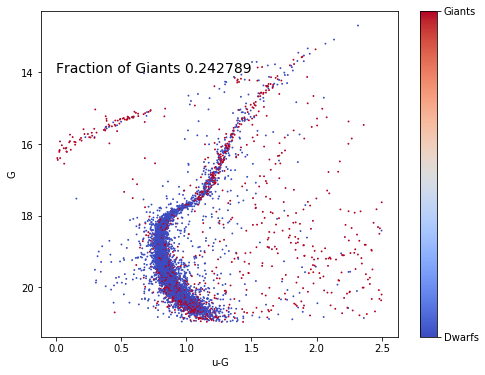

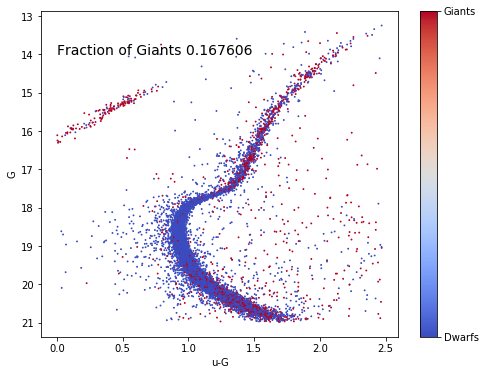

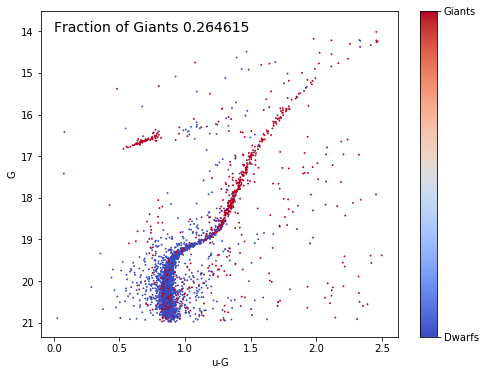

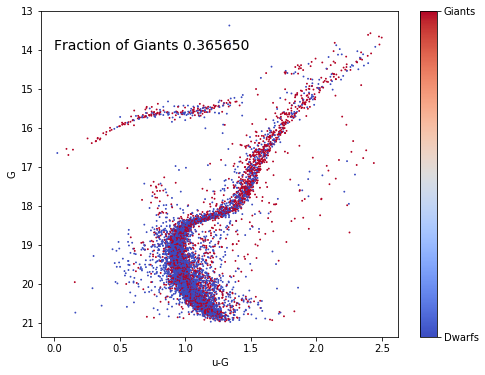

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('u-G')
plt.ylabel('G')
cax = plt.scatter((inputs_NGC6341['u']-inputs_NGC6341['G']).values, inputs_NGC6341['G'].values, s=0.75, c=inputs_NGC6341['class'], cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Dwarfs', 'Giants'])
plt.gca().invert_yaxis()
plt.annotate(r"Fraction of Giants %f"%(float(inputs_NGC6341_giants.shape[0])/inputs_NGC6341.shape[0]), xy=(0,14.0), color='black',size=14)
plt.savefig('./plots/1st_col/NGC6341_1st_col')

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('u-G')
plt.ylabel('G')
cax = ax.scatter((inputs_NGC6205['u']-inputs_NGC6205['G']).values, inputs_NGC6205['G'].values, s=0.75, c=inputs_NGC6205['class'], cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Dwarfs', 'Giants'])
plt.gca().invert_yaxis()
ax.annotate(r"Fraction of Giants %f"%(float(inputs_NGC6205_giants.shape[0])/inputs_NGC6205.shape[0]), xy=(0,14.0), color='black',size=14)
plt.savefig('./plots/1st_col/NGC6205_1st_col')

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('u-G')
plt.ylabel('G')
cax = plt.scatter((inputs_NGC5466['u']-inputs_NGC5466['G']).values, inputs_NGC5466['G'].values, s=0.75, c=inputs_NGC5466['class'], cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Dwarfs', 'Giants'])
plt.gca().invert_yaxis()
plt.annotate(r"Fraction of Giants %f"%(float(inputs_NGC5466_giants.shape[0])/inputs_NGC5466.shape[0]), xy=(0,14.0), color='black',size=14)
plt.savefig('./plots/1st_col/NGC5466_1st_col')


fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('u-G')
plt.ylabel('G')
cax = plt.scatter((inputs_NGC5272['u']-inputs_NGC5272['G']).values, inputs_NGC5272['G'].values, s=0.75, c=inputs_NGC5272['class'], cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Dwarfs', 'Giants'])
plt.gca().invert_yaxis()
plt.annotate(r"Fraction of Giants %f"%(float(inputs_NGC5272_giants.shape[0])/inputs_NGC5272.shape[0]), xy=(0,14.0), color='black',size=14)
plt.savefig('./plots/1st_col/NGC5272_1st_col')